In [1]:
import pandas as pd
import numpy as np
import sobol_seq as sob
from multi_step import multi_step, utils
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import wraps
gpflow.config.set_default_float("float32")

Setting the default backend to "tensorflow". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: tensorflow


In [2]:
plotGP = True

def GPPlotter(stage, data, xdim, stageVar, stageOutputVar):
    ## generate indices for sampling
    xx = data.to_numpy(dtype=np.float32)[:,:xdim]
    sortedInd = np.argsort(xx[:,stageVar])
    ind = np.unique(np.random.randint(xx.shape[0], size=15))

    ## obtain the test points for prediction
    xx = xx[sortedInd[ind]]
    yy = data.to_numpy(dtype=np.float32)[sortedInd[ind],xdim:]

    ## predict mean and variance of latent GP at test points
    mean, var = stage.model.predict_f(Xnew=xx)
    # mean = mean + stage.model.Y_offset

    ## generate 10 samples from posterior
    tf.random.set_seed(1)  # for reproducibility
    samples = stage.model.predict_f_samples(Xnew=xx, num_samples=10)
    # samples = samples

    ## plot
    plt.figure(figsize=(12, 6))
    plt.plot(xx[:,stageVar], yy[:,stageOutputVar], "kx", mew=2)
    plt.plot(xx[:,stageVar], mean[:,stageOutputVar], "C0", lw=2)
    plt.fill_between(
        xx[:, stageVar],
        mean[:, stageOutputVar] - 1.96 * np.sqrt(var[:, stageOutputVar]),
        mean[:, stageOutputVar] + 1.96 * np.sqrt(var[:, stageOutputVar]),
        color="C0",
        alpha=0.2,
    )

    plt.plot(xx[:,stageVar], samples[:, :, stageOutputVar].numpy().T, "C0", linewidth=0.5)

In [3]:
# Define the stage input ranges

#'T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'
stage1Ranges = [[70,110],[0.15,0.35],[4,7],[0.4,0.8],[0,0.35],[0.05,0.4],[0.1,270]]
#'a-terpinene','g-terpinene','terpinolene','T','Q_liq','Q_gas','radical_initiator','time'
stage2Ranges = [[0,2],[0,2],[0,2],[80,150],[0.1,5],[5,120],[0,2],[0,240]]
# 'out_11','out_12','out_13','out_14','out_2','ox','T'
stage3Ranges = [[0,1],[0,3],[0,2],[0,2],[0,1],[0,21],[100,150]]

In [4]:
def Stage_3(inputs):
    out_3 = 71.05*(1-np.exp(-0.1657 * inputs[:,5]))*(1-np.exp(-0.2*(inputs[:,6]-100)))
    out_4 = 1.04 * out_3/100 * ( (inputs[:,3] + inputs[:,4]/100 * (inputs[:,0]+inputs[:,1]+inputs[:,2])) )
    return out_4

def sobolSequenceConditions(condition_ranges, num_points):
    """"""
    dimensions = len(condition_ranges)
    sobol_sequence = sob.i4_sobol_generate(dimensions, num_points)
    lower_bounds = np.array([condition[0] for condition in condition_ranges])
    upper_bounds = np.array([condition[1] for condition in condition_ranges])
    ranges = upper_bounds - lower_bounds
    offset = np.tile(lower_bounds,(num_points,1))
    conditions = sobol_sequence * ranges + offset
    return np.array(conditions)

# ('out_11','out_12','out_13','out_14','out_2','ox','T')
stage_3_inputs = sobolSequenceConditions(stage3Ranges,20)
stage_3_outputs = Stage_3(stage_3_inputs)

In [5]:
data_s1 = pd.read_csv('data/Stage_1.csv')
data_s2 = pd.read_csv('data/Stage_2.csv')
data_s3 = pd.DataFrame(np.concatenate((stage_3_inputs,np.expand_dims(stage_3_outputs,1)),axis=1),
          columns=['out_11','out_12','out_13','out_14','out_2','ox','T','out_3'])

In [6]:
def centreXArguments(X_offset):
    def centreX(func):
        @wraps(func)
        def centre(*args, **kwargs):
            print(kwargs)
            print(X_offset)
            kwargs['Xnew'] = kwargs['Xnew'] - X_offset.values
            print('kwargs: ', kwargs['Xnew'][0])
            print(type(kwargs['Xnew'][0]))
            func(*args, **kwargs)
        return centre
    return centreX

def fit_stage(data, inputHeaders, outputHeaders):
    X = data[inputHeaders]
    X_offset = X.mean(axis=0)
    # X = X - X_offset
    Y = data[outputHeaders]
    kernel = gpflow.kernels.Matern12()
    gp = gpflow.models.GPR(data=(X,Y), kernel=kernel)
    # gpflow.utilities.print_summary(gp)
    opt = gpflow.optimizers.Scipy()
    optLogs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=1000))
    # gpflow.utilities.print_summary(gp)
    gp.X_offset = X_offset

    centreX = centreXArguments(X_offset)

    # gp.predict_f = centreX(gp.predict_f)
    # gp.predict_f(Xnew=data[inputHeaders])
    # gp.predict_f_samples = centreX(gp.predict_f_samples)

    return gp

In [7]:
# Fit the stages
# data_s1 = data_s1[['T','R','Ch2so4','a-pinene','3-carene','b-pinene','time','limonene','alpha-terpinene','gamma-terpinene','terpinolene','p-cymene',
#                                        'alpha-terpinene-output','gamma-terpinene-output','terpinolene-output','p-cymene-output']]
# stage1Model = fit_stage(data_s1, inputHeaders=['T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'],
#                         outputHeaders=['limonene','alpha-terpinene','gamma-terpinene','terpinolene','p-cymene',
#                                        'alpha-terpinene-output','gamma-terpinene-output','terpinolene-output','p-cymene-output'])
data_s1 = data_s1[['T','R','Ch2so4','a-pinene','3-carene','b-pinene','time','alpha-terpinene-output',
                   'gamma-terpinene-output','terpinolene-output','p-cymene-output']]
stage1Model = fit_stage(data_s1, inputHeaders=['T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'],
                        outputHeaders=['alpha-terpinene-output','gamma-terpinene-output','terpinolene-output','p-cymene-output'])
data_s2 = data_s2[['a-terpinene','g-terpinene','terpinolene','T','Q_liq','Q_gas','radical_initiator','time','Y2']]
stage2Model = fit_stage(data_s2, inputHeaders=['a-terpinene','g-terpinene','terpinolene','T','Q_liq','Q_gas','radical_initiator','time'],
                        outputHeaders=['Y2'])
data_s3 = data_s3[['out_11','out_12','out_13','out_14','out_2','ox','T','out_3']]
stage3Model = fit_stage(data_s3, inputHeaders=['out_11','out_12','out_13','out_14','out_2','ox','T'],
                        outputHeaders=['out_3'])

In [8]:
# Generate the multi_step class
multi_step_graph = multi_step.multi_step_graph('adam', learning_rate=0.01, training='random', eps=1e-4)

In [9]:
# Load the models into the framework

#Define the stages
# stageID, stageModel, conditionRanges, followingStages (followingStageID, feedingVariables)
stage1 = utils.stage(0, stage1Model, stage1Ranges, outputDimension=9, followingStages=[[1, [0,1,2]], [2, [0,1,2,3]]])
stage2 = utils.stage(1, stage2Model, stage2Ranges[3:], outputDimension=1, followingStages=[[2,[0]]])
stage3 = utils.stage(2, stage3Model, stage3Ranges[5:], outputDimension=1)

stages = [stage1, stage2, stage3]

multi_step_graph.loadModels(stages)

c:\users\geeso\virtualenvironments\multi-step-framework\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


Stage 3


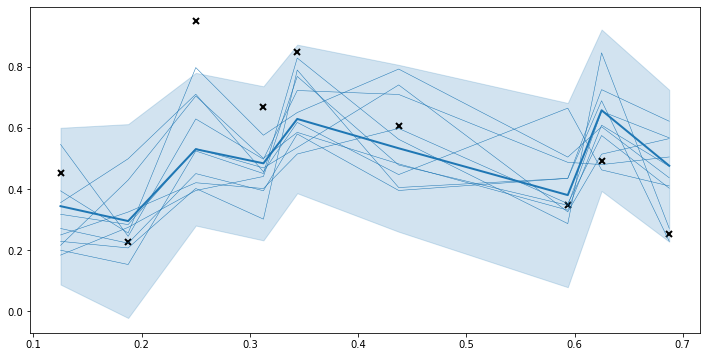

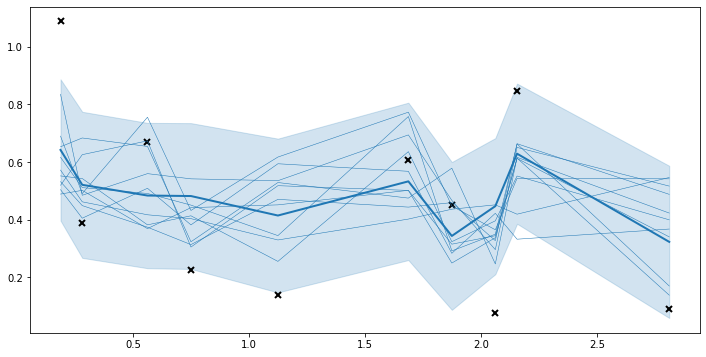

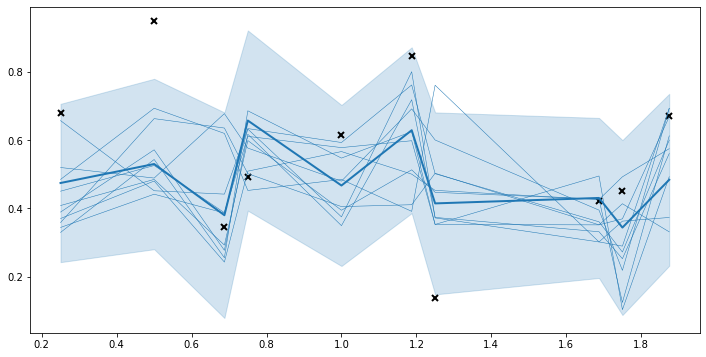

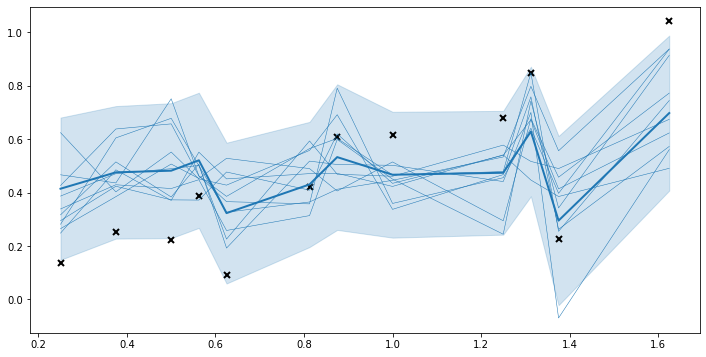

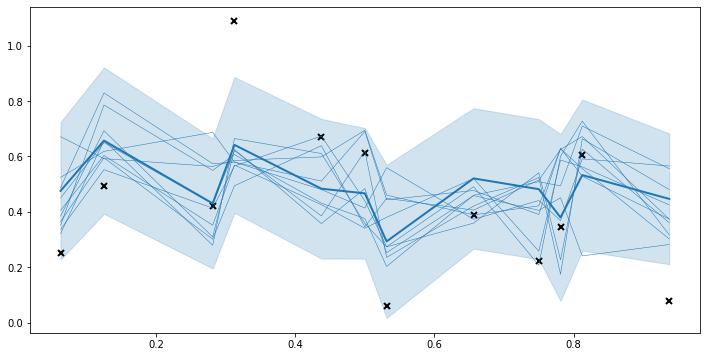

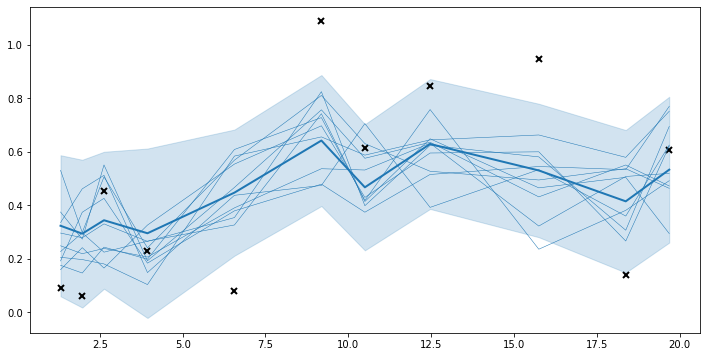

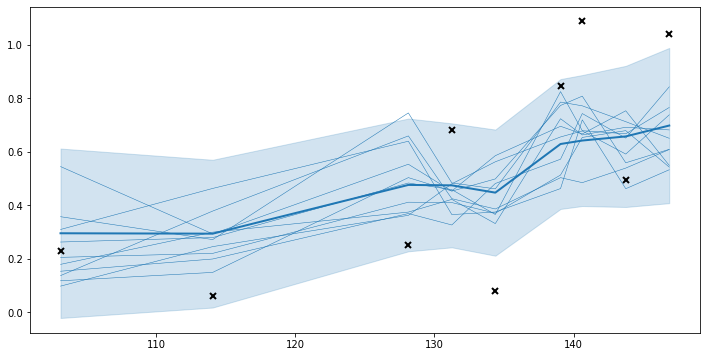

In [10]:
if plotGP == True:
    # print('Stage 1')
    # GPPlotter(stage1,data_s1,7,2,0)
    # # GPPlotter(stage2,data_s2,8,0,0)
    # print('Stage 3')
    # GPPlotter(stage3,data_s3,7,5,0)
    # print('Stage 2')
    # for i in range(8):
    #     GPPlotter(stage2,data_s2,8,i,0)
    print('Stage 3')
    for i in range(7):
        GPPlotter(stage3,data_s3,7,i,0)

In [11]:
# Define the objective functions

def objectiveFunction1(var1):
    return var1 * 10

def objectiveFunction2(*args):
    # stage1: 'T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'
    # stage2: 'T','Q_liq','Q_gas','radical_initiator','time'
    # stage3: 'ox','T'

    materialUnitCosts = tf.constant([1.0,1.0,1.0,1.0,1.0,1.0])
    materialIndices = [2,3,4,5,10,12]
    timeCostConstant = 0.1
    heatingCostConstant = 0.1

    # materialAmounts = tf.concat([*args[2:6],args[10],args[12]], axis=0)
    # materialAmounts = tf.constant(args[2:6]+[args[10]]+[args[12]])

    # materialCosts = tf.tensordot(materialAmounts, materialUnitCosts, axes=1)
    # materialCosts = tf.reduce_sum(materialAmounts)
    for count, index in enumerate(materialIndices):
        try:
            materialCosts += materialUnitCosts[count] * args[index]
        except:
            materialCosts = materialUnitCosts[index] * args[index]
    timeCosts = (args[6] + args[11]) * timeCostConstant
    heatingCosts = (args[0] + args[7] + args[13]) * heatingCostConstant
    print('Time: {}, Heat: {}, Materials: {}'.format(timeCosts,heatingCosts,materialCosts))
    return -(timeCosts + heatingCosts + materialCosts)

# def objectiveFunction3(*args):
#     # stage1: 'T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'
#     # stage2: 'T','Q_liq','Q_gas','radical_initiator','time'
#     # stage3: 'ox','T'
#
#     materialUnitCosts = np.array([1,1,1,1,1,1])
#     timeCostConstant = 5
#     heatingCostConstant = 5
#
#     materialAmounts = tf.constant(list(args[2:6])+[args[10],args[12]])
#
#     materialCosts = tf.tensordot(materialAmounts, materialUnitCosts)
#     timeCosts = (args[6] + args[11]) * timeCostConstant
#     heatingCosts = (args[0] + args[7] + args[13]) * heatingCostConstant
#     return materialCosts + timeCosts + heatingCosts

# Define the objective objects including the objective functions and the IDs of relevant variables/outputs
# Define objective variables with form: [stage, 'input'/'output', stage variable]
objective1 = utils.objective(objectiveFunction1, [[stage3,'outputs',0]])
objective2 = utils.objective(objectiveFunction2,[
    [stage1,'inputs',0],[stage1,'inputs',1],[stage1,'inputs',2],[stage1,'inputs',3],[stage1,'inputs',4],[stage1,'inputs',5],[stage1,'inputs',6],
    [stage2,'inputs',3],[stage2,'inputs',4],[stage2,'inputs',5],[stage2,'inputs',6],[stage2,'inputs',7],
    [stage3,'inputs',5],[stage3,'inputs',6]
])
# objective3 = utils.objective(objectiveFunction3,[
#     [stage1,'inputs',0],[stage1,'inputs',1],[stage1,'inputs',2],[stage1,'inputs',3],[stage1,'inputs',4],[stage1,'inputs',5],[stage1,'inputs',6],
#     [stage2,'inputs',3],[stage2,'inputs',4],[stage2,'inputs',5],[stage2,'inputs',6],[stage2,'inputs',7],
#     [stage3,'inputs',5],[stage3,'inputs',6]
# ])

# objectives = [objective1, objective2]
objectives = [objective1, objective2]
# objectives = [objective1]

In [12]:
# Define the objectives for the framework
multi_step_graph.defineObjectives(objectives)

In [13]:
# Train
# numObjectiveSamples, numStartSamples, preferenceEncodeDim, hyperparameterGeneratorDim, epochs=5, h_dim=5, n_layers=4, network_type='GATConv', **kwargs
inputs = multi_step_graph.train(5, 5, 20, 350, epochs=10, h_dim=20, n_layers=4, network_type='GATConv', num_heads=4)

Starting training
Time: 27.924148559570312, Heat: 29.82636833190918, Materials: 14.0068359375
Time: 25.505001068115234, Heat: 33.0, Materials: 18.0
rl<0 
 rl=[-0.06331476  1.0633147 ]
Time: 25.505001068115234, Heat: 33.0, Materials: 18.0
Weightings: [0.51848704 0.48151293], Epoch: 0, Loss: 69.28926849365234, Objective values: [  4.2306104 -76.505005 ]
Time: 27.924148559570312, Heat: 29.82636833190918, Materials: 14.0068359375
Time: 25.250059127807617, Heat: 32.92000198364258, Materials: 17.864505767822266
rl<0 
 rl=[-0.06358241  1.0635824 ]
Time: 27.924148559570312, Heat: 29.82636833190918, Materials: 14.0068359375
Time: 24.996408462524414, Heat: 32.840267181396484, Materials: 17.72927474975586
rl<0 
 rl=[-0.06385393  1.0638539 ]
Time: 27.924148559570312, Heat: 29.82636833190918, Materials: 14.0068359375
Time: 24.74507713317871, Heat: 32.76300048828125, Materials: 17.597217559814453
rl<0 
 rl=[-0.06413378  1.0641338 ]
Time: 27.924148559570312, Heat: 29.82636833190918, Materials: 14.006

KeyboardInterrupt: 

In [ ]:
# Get optimised inputs based on desired objective weightings
generatedInputs, objectiveValues = multi_step_graph.getConditions([0.5,0.5])
print(generatedInputs)
print(objectiveValues)

In [ ]:
# Create plot of objectives with different weightings
weightings = np.arange(0.025,0.975,0.025)
objectiveValuesList = []
for weighting in weightings:
    generatedInputs, objectiveValues = multi_step_graph.getConditions([weighting,1-weighting])
    objectiveValuesList.append(objectiveValues)
objectiveValuesArray = np.squeeze(np.array(objectiveValuesList))

In [ ]:
pareto = plt.figure(figsize=(12, 6))
ax = pareto.add_axes([0.1, 0.1, 0.8, 0.8])
ax.scatter(objectiveValuesArray[:,0],objectiveValuesArray[:,1])
ax.set_xscale('log')
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
pareto.savefig('././figures/pareto.pdf')

In [ ]:
print(objectiveValuesArray)
# TSEMOInputs = [[95,0.24,6,0.5332,0.038,0.3687,267],[],[]]
# 0.5999    0.0917    0.5459    0.1211    0.2591    0.3038    0.2397    0.4270